In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics
!pip install deuces

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import numpy as np
import cv2
import os
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from deuces import Card, Evaluator, Deck

def analyze_poker_hand():

    model_path = os.path.join("/content/drive/MyDrive/Playing_Cards", "My_card_model", "weights", "best.pt")
    model = YOLO(model_path)

    threshold = 0.45 # Threshold 수정 가능
    font = cv2.FONT_HERSHEY_COMPLEX

    image_path = input("Input image location: ")

    try:
        frame = cv2.imread(image_path)
        if frame is None:
            raise FileNotFoundError(f"Imamge not found: {image_path}")
    except FileNotFoundError as e:
        print(e)
        return

    H, W, _ = frame.shape

    results = model(frame)[0]

    card_detections = {}
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        if score > threshold:
            label_name = results.names[int(class_id)].upper()
            center_y = (y1 + y2) / 2

            if label_name not in card_detections:
                card_detections[label_name] = []
            card_detections[label_name].append(center_y)

    card_positions = []
    for card_name, y_coords in card_detections.items():
        avg_y = np.mean(y_coords)
        card_positions.append({'name': card_name, 'y_pos': avg_y})

    card_positions.sort(key=lambda x: x['y_pos'])

    com_cards = set()
    hand_cards = set()
    for i, card_data in enumerate(card_positions):
      ###### 여기 변경
      if i >= len(card_positions) - 2:
          hand_cards.add(card_data['name'])
      else:
            if len(com_cards) < 5:
              com_cards.add(card_data['name'])
      ######

    def convert_to_deuces_format(yolo_label):
        if yolo_label.startswith('10'):
            rank = 'T'
            suit = yolo_label[2]
        else:
            rank = yolo_label[0]
            suit = yolo_label[1]


        return rank + suit.lower()

    deuces_com = [Card.new(convert_to_deuces_format(c)) for c in com_cards]
    deuces_hand = [Card.new(convert_to_deuces_format(c)) for c in hand_cards]

    evaluator = Evaluator()
    deck = Deck()

    known_cards = deuces_com + deuces_hand
    for card in known_cards:
        if card in deck.cards:
            deck.cards.remove(card)

    win_count = 0
    tie_count = 0
    simulations = 10000  # 시뮬레이션 횟수

    for _ in range(simulations):
        temp_deck = Deck()
        temp_deck.cards = [c for c in temp_deck.cards if c not in known_cards]

        try:
            num_cards_to_draw = 2 + (5 - len(deuces_com))
            if len(temp_deck.cards) < num_cards_to_draw:
                continue

            draw_cards = temp_deck.draw(num_cards_to_draw)
            opp_hand = draw_cards[:2]
            remaining_board = draw_cards[2:]
        except ValueError:
            continue

        temp_com = deuces_com + remaining_board

        my_rank = evaluator.evaluate(deuces_hand, temp_com)
        opp_rank = evaluator.evaluate(opp_hand, temp_com)

        if my_rank < opp_rank:
            win_count += 1
        elif my_rank == opp_rank:
            tie_count += 1

    total_simulations = simulations
    if total_simulations > 0:
        win_probability = (win_count + tie_count / 2) / total_simulations * 100
    else: # Tie는 고려하지 않기로 함
        win_probability = 0

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        if score > threshold:
            label_name = results.names[int(class_id)].upper()
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, label_name, (int(x1), int(y1 - 10)), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    com_list_str = ", ".join(sorted(list(com_cards)))
    hand_list_str = ", ".join(sorted(list(hand_cards)))

    cv2.putText(frame, f"Community: {com_list_str}", (10, 30), font, 0.7, (10, 10, 10), 2)
    cv2.putText(frame, f"Hand: {hand_list_str}", (10, 60), font, 0.7,(10, 10, 10), 2)
    cv2.putText(frame, f"Win Probability: {win_probability:.2f}%", (10, 90), font, 0.7,  (10, 10, 10), 2)

    print(f"Community cards: {com_list_str}")
    print(f"Hand cards: {hand_list_str}")
    print(f"Win Probability: {win_probability:.2f}%")

    cv2_imshow(frame)



Input image location: /content/card7_resized.jpg

0: 480x640 2 2Cs, 2 2Ss, 2 3Cs, 2 4Cs, 2 5Cs, 2 9Hs, 2 ACs, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)
Community cards: 2C, 2S, 3C, 4C, AC
Hand cards: 5C, 9H
Win Probability: 100.00%


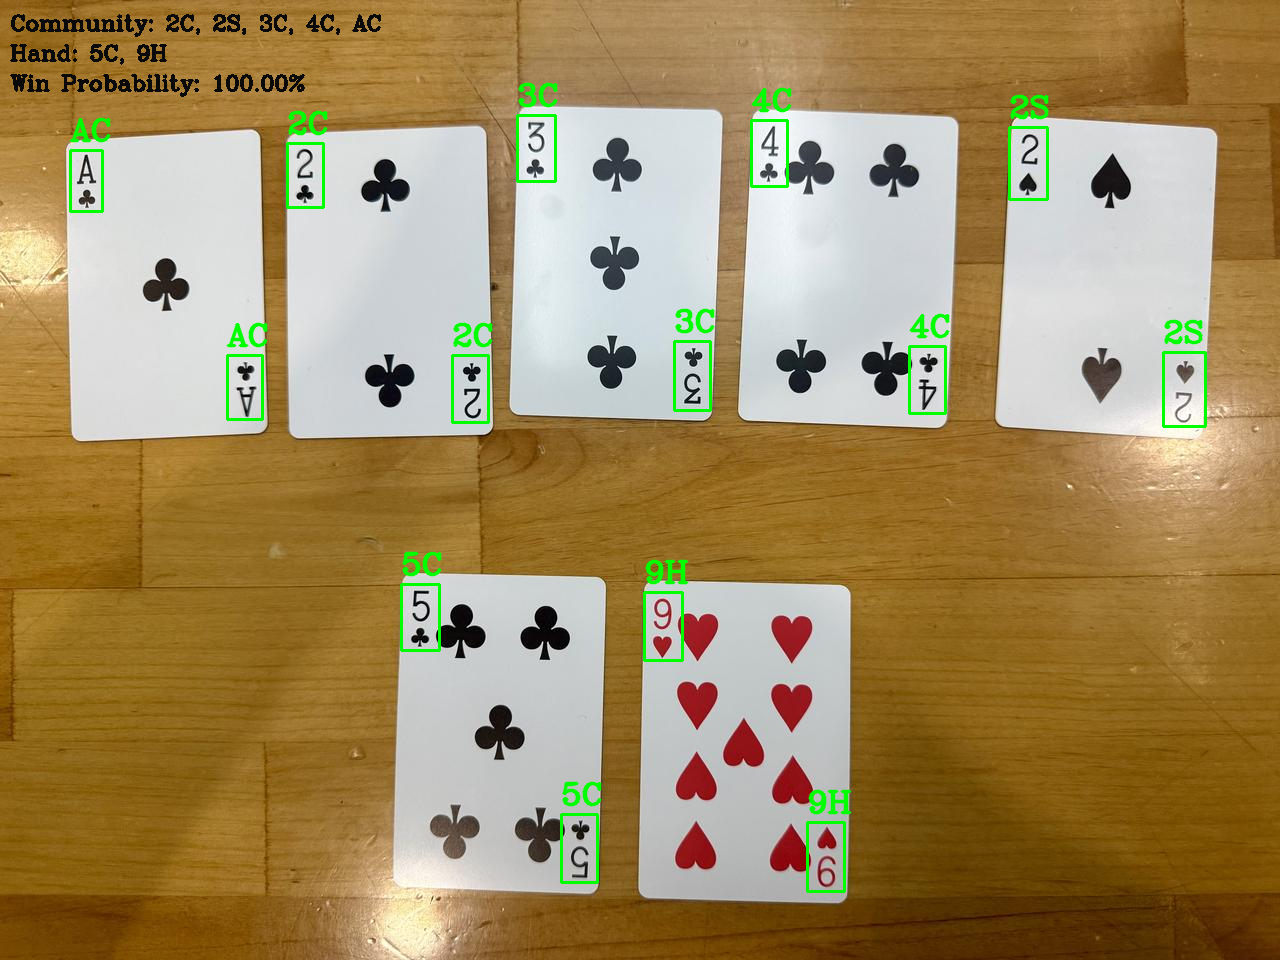

In [ ]:
analyze_poker_hand()

Input image location: /content/resized_image.jpg

0: 480x640 2 2Cs, 2 2Ss, 2 3Cs, 2 4Cs, 2 5Cs, 2 9Hs, 2 ACs, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Community cards: 2C, 2S, 3C, 4C, AC
Hand cards: 5C, 9H
Win Probability: 100.00%


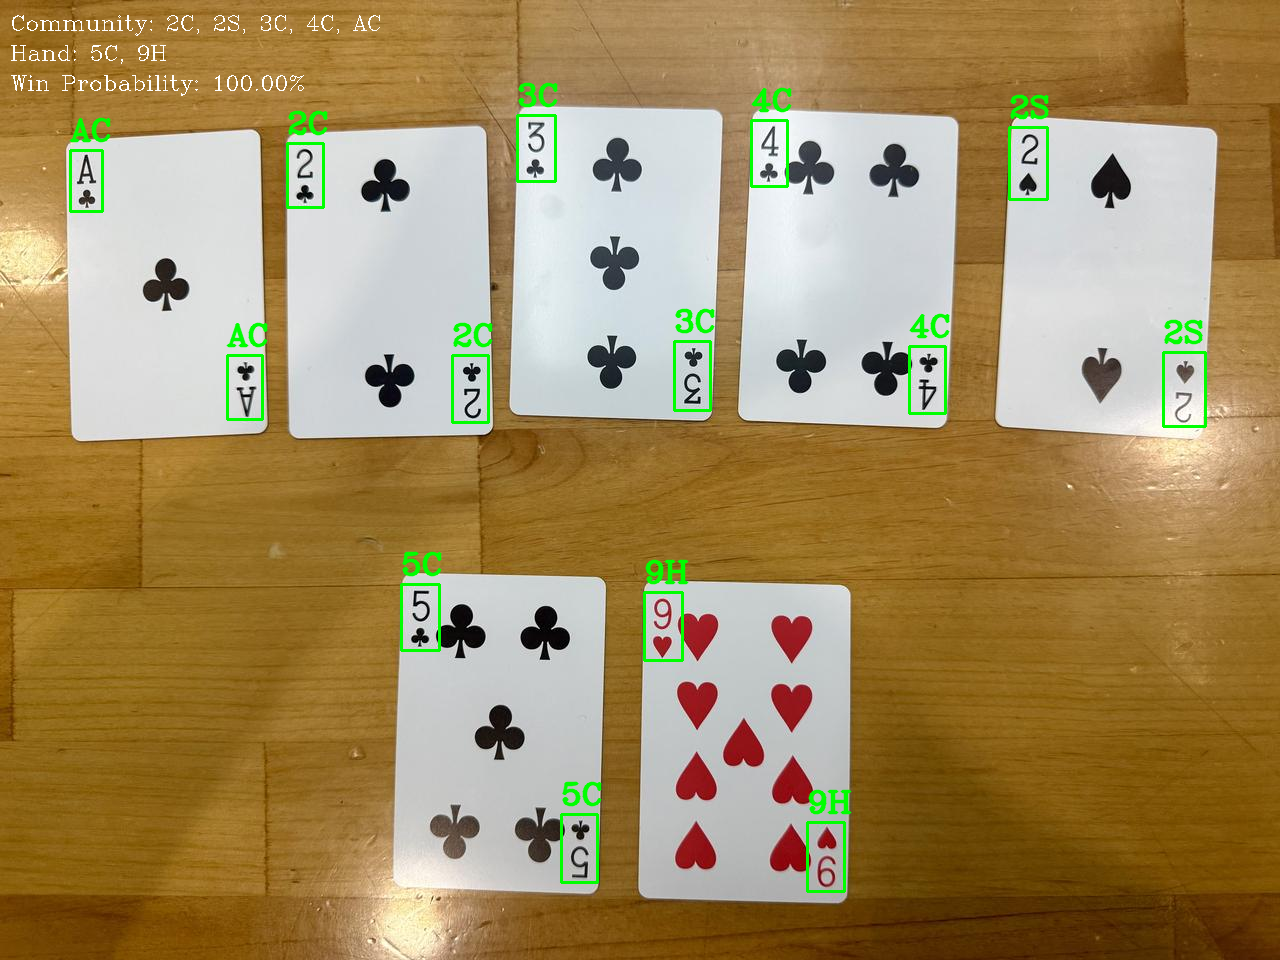

In [ ]:
analyze_poker_hand()

Input image location: /content/card2_resized.jpg

0: 480x640 2 10Hs, 2 4Ss, 2 9Hs, 2 AHs, 2 JHs, 1 KD, 1 KH, 1 QD, 1 QH, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Community cards: 4S, AH, JH, KH, QH
Hand cards: 10H, 9H
Win Probability: 100.00%


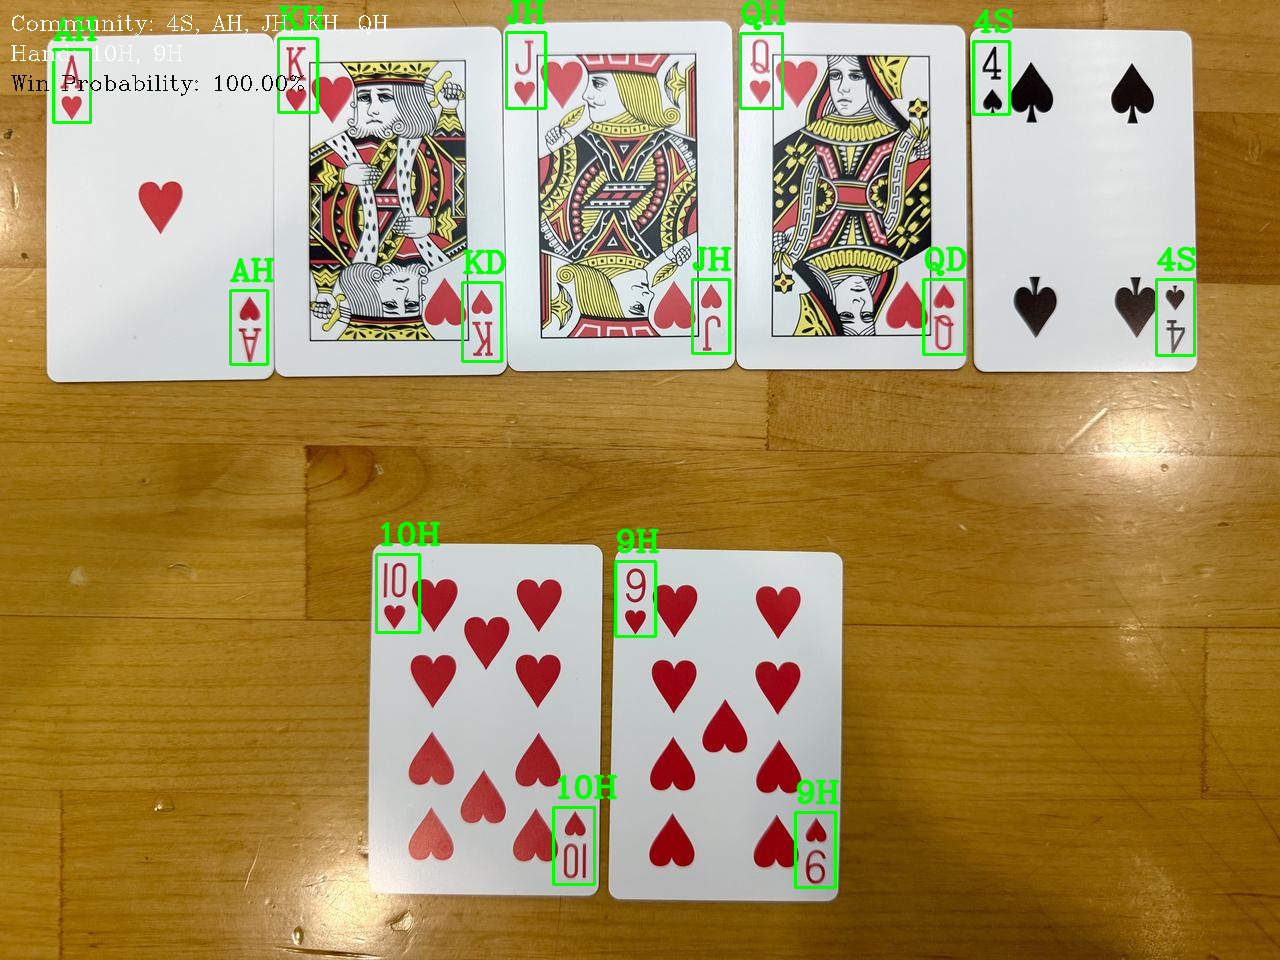

In [ ]:
analyze_poker_hand()

______________________________________

In [ ]:
!pip install Pillow

In [ ]:
from PIL import Image

def imghw():
  try:
      img = Image.open(input("img path:"))
      width, height = img.size
      print(f"W: {width}")
      print(f"H: {height}")
      print(f"{width} x {height}")

  except FileNotFoundError:
      print("img not found.")


In [ ]:
def hwchange():
  img_path = input("img path:")
  name = img_path.split('/')[-1]
  real_name = name.split('.')[0]
  try:
    img = Image.open(img_path)
    new_width = 1280
    new_height = 960
    new_size = (new_width, new_height)
    resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
    rgb_img = resized_img.convert("RGB")
    rgb_img.save(f"{real_name}_resized.jpg")

    print(f"Chnaged to {new_width} x {new_height} as  '{real_name}_image.jpg'.")

  except FileNotFoundError:
      print("Image not found.")

In [ ]:
imghw()

img path:/content/card6_resized.jpg
W: 1280
H: 960
1280 x 960


In [ ]:
hwchange()

img path:/content/card7.jpeg
Chnaged to 1280 x 960 as  'card7_image.jpg'.


--------------------------------------